In [123]:
import requests
import pandas as pd
import spacy
from textstat import textstat
import re
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
import torch
import pickle


In [124]:
nlp = spacy.load("en_core_web_sm")


In [125]:
print(torch.__version__)
print(torch.version.cuda)  # Should not be None
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

2.7.1+cu118
11.8
True
1
NVIDIA GeForce RTX 2070 with Max-Q Design


In [126]:
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()
if torch.cuda.is_available():
    print("cuda available!")
    model.to("cuda")
else:
    print('cuda not available!')


cuda available!


In [127]:
import requests
from tqdm import tqdm


def get_category_members(category, cmtype="page", namespace=0, limit=500):
    """
    Fetches members of a given Wikipedia category.

    :param category: Category name without the 'Category:' prefix
    :param cmtype: 'page', 'subcat', or 'file'
    :param namespace: Namespace index (0 for articles)
    :param limit: Number of results per request (max 500 for users)
    :returns: List of dicts with 'pageid' and 'title'
    """
    S = requests.Session()
    URL = "https://en.wikipedia.org/w/api.php"
    members = []
    params = {
        "action": "query",
        "format": "json",
        "list": "categorymembers",
        "cmtitle": f"Category:{category}",
        "cmtype": cmtype,
        "cmlimit": limit,
        "cmnamespace": namespace,
    }
    while True:
        res = S.get(URL, params=params)
        data = res.json()
        batch = data.get("query", {}).get("categorymembers", [])
        members.extend(batch)
        if "continue" in data:
            params.update(data["continue"])
        else:
            break
    return members


In [128]:
def fetch_articles_from_categories(categories, include_subcats=False, max_subcat_depth=1):
    """
    Given a list of category names, fetches all articles in them.
    Optionally includes pages from subcategories up to specified depth.

    :param categories: List of category names (strings without prefix)
    :param include_subcats: Whether to traverse into subcategories
    :param max_subcat_depth: Maximum depth for subcategory traversal
    :returns: Set of page titles
    """
    all_articles = set()
    seen_cats = set()

    def _recurse(cat, depth):
        if cat in seen_cats or depth < 0:
            return
        seen_cats.add(cat)

        # Fetch pages
        pages = get_category_members(cat, cmtype="page")
        for p in pages:
            all_articles.add(p["title"])

        if include_subcats and depth > 0:
            subcats = get_category_members(cat, cmtype="subcat", namespace=14)
            for sc in subcats:
                sc_name = sc["title"].replace("Category:", "")
                _recurse(sc_name, depth - 1)

    for cat in tqdm(categories, desc="Traversing categories"):
        _recurse(cat, max_subcat_depth)

    return all_articles


In [185]:
categories = [
    "Politics",
    "History",
]

In [189]:

articles = fetch_articles_from_categories(categories, include_subcats=False, max_subcat_depth=2)
print(f"Fetched {len(articles)} articles from categories and subcategories.")

# Save to file or integrate into your pipeline
with open("history_politics_articles.pkl", "wb") as f:
    pickle.dump(articles, f)

Traversing categories:   0%|          | 0/2 [00:00<?, ?it/s]

Fetched 101 articles from categories and subcategories.


In [190]:
# Load the articles from the saved file
with open("history_politics_articles.pkl", "rb") as f:
    articles = pickle.load(f)
print(articles)

{'Anti-incumbency', 'Democratic intervention', 'Two-step flow of communication', 'New public management', 'Glossary of history', 'Referendum', 'Wrongful detention', 'Public opinion', 'Election science', 'Religion in politics', 'Phantom border', 'Fan activism', 'Action alert', 'Political journalism', 'Hoskins House Historic District', 'Twinning (cooperation)', 'Unseating', 'Political faction', 'Public interest', 'Human rights', 'Interwar Bulgaria', 'Political polarization', 'Extrajudicial killing', 'National memory', 'Postfeminism', 'Punk ideologies', 'Global policeman', 'Political capitalism', 'Politics', 'Election', 'Political cognition', 'Political will', 'Comparative politics', 'Democratization', 'Political demography', 'Austerity', 'Local history', 'Diplomatic mission', 'Libertarian anarchism', 'Incompatibility rule', 'Index of politics articles', 'Gastronationalism', 'Regional autonomy', 'Term of office', 'Countback', 'Political crisis', 'Pro-Truth Pledge', 'Political bias', 'Gree

In [133]:
# sample_pages = [
#     "Python (programming language)",
#     "Machine learning",
#     "Artificial intelligence"
# ]


In [134]:
START_TIMESTAMP = "2022-05-01T00:00:00Z"
END_TIMESTAMP = "2023-05-31T23:59:59Z"


In [135]:
columns = [
    "page_title", "rev_id", "timestamp", "user", "is_bot", "content"
]
tiny_revs = pd.DataFrame(columns=columns)


In [136]:
def is_bot_username(username: str) -> bool:
    return username.lower().endswith("bot")


In [191]:
import requests
import pandas as pd
from dateutil import parser


def fetch_revision_snapshots(
        title: str,
        start_ts: str,
        end_ts: str,
        freq: str = "2W",
        bot_test_fn: callable = None,
        carry_forward: bool = True,

) -> pd.DataFrame:
    """
    Fetches all revisions for `title` between start_ts and end_ts (inclusive),
    then returns a DataFrame of snapshots at the given frequency.

    Args:
      title      : Wikipedia page title
      start_ts   : ISO8601 timestamp string, e.g. "2020-01-01T00:00:00Z"
      end_ts     : ISO8601 timestamp string, e.g. "2024-12-31T23:59:59Z"
      freq       : pandas offset alias for sampling, e.g. "7D" (7 days),
                   "W-MON" (weekly on Mondays), "1M" (monthly), etc.
      bot_test_fn: optional fn(username)->bool to flag bots. If None,
                   no bot flag is set.
      carry_forward : reuse last snapshot if no newer revision

    Returns:
      DataFrame with columns
        ['page_title', 'snapshot_ts', 'rev_id', 'timestamp', 'user', 'is_bot', 'content']
      where `snapshot_ts` is each sample point, and the row is the latest
      revision at or before that time.
    """
    # 1) Fetch all revisions via the API
    S, URL = requests.Session(), "https://en.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "format": "json",
        "prop": "revisions",
        "rvprop": "ids|timestamp|user|comment|content",
        "rvstart": end_ts,
        "rvend": start_ts,
        "rvlimit": "max",
        "titles": title,
        "redirects": 1,
        "rvslots": "main",
    }
    all_revs = []
    while True:
        resp = S.get(URL, params=params).json()
        pages = resp["query"]["pages"]
        pid = next(iter(pages))
        if "revisions" not in pages[pid]:
            break
        for rev in pages[pid]["revisions"]:
            ts = rev["timestamp"]
            all_revs.append({
                "rev_id": rev["revid"],
                "timestamp": parser.isoparse(ts),
                "user": rev["user"],
                "is_bot": bot_test_fn(rev["user"]) if bot_test_fn else False,
                "content": rev.get("slots", {}).get("main", {}).get("*", "")
            })
        if "continue" in resp:
            params.update(resp["continue"])
        else:
            break

    # 2) Build a DataFrame and sort by timestamp
    df = pd.DataFrame(all_revs)
    if df.empty:
        return pd.DataFrame()  # no revisions in interval
    df = df.sort_values("timestamp").reset_index(drop=True)

    # 3) Create a list of sample timestamps
    #    We interpret start_ts/end_ts as inclusive bounds:
    sample_times = pd.date_range(
        start=parser.isoparse(start_ts),
        end=parser.isoparse(end_ts),
        freq=freq
    )

    # 4) For each sample time, pick the last revision <= that time
    snapshots = []
    idx = 0
    last_row = None
    for snap_t in sample_times:
        has_new_revision = False
        # Advance through revisions up to this snapshot time
        while idx < len(df) and df.loc[idx, "timestamp"] <= snap_t:
            last_row = df.loc[idx]
            has_new_revision = True
            idx += 1
        # If no revision yet ever, skip snapshot
        if last_row is None:
            continue
        # If carry_forward is False and no new revision in this interval, skip
        if not carry_forward and not has_new_revision:
            continue
        # Otherwise, record the snapshot
        row = last_row.copy()
        row["page_title"] = title
        row["snapshot_ts"] = snap_t
        snapshots.append(row)

    snap_df = pd.DataFrame(snapshots)
    cols = ["page_title", "snapshot_ts", "rev_id", "timestamp", "user", "is_bot", "content"]
    return snap_df[cols]



In [192]:
sample_pages = articles

In [193]:
rows = []
for pg in sample_pages:
    revs = fetch_revision_snapshots(
        pg, START_TIMESTAMP, END_TIMESTAMP,
        freq="1ME", bot_test_fn=is_bot_username, carry_forward=True
    )
    # Convert DataFrame rows to dictionaries
    for _, r in revs.iterrows():
        rows.append({
            "page_title": pg,
            "rev_id": r["rev_id"],
            "timestamp": r["timestamp"],
            "user": r["user"],
            "is_bot": r["is_bot"],
            "content": r["content"]
        })

tiny_revs = pd.DataFrame(rows)

In [194]:
tiny_revs.head(200)
# tiny_revs.shape


,page_title,rev_id,timestamp,user,is_bot,content
0,Anti-incumbency,1150902326,2023-04-20 18:02:02+00:00,Citation bot,True,'''Anti-incumbency''' is sentiment in favor of...
1,Anti-incumbency,1154692334,2023-05-14 02:12:24+00:00,120.17.19.119,False,'''Anti-incumbency''' is sentiment in favor of...
2,Democratic intervention,1102834116,2022-08-07 04:20:40+00:00,Liz,False,{{Use mdy dates|date=August 2021}}\n[[File:060...
3,Democratic intervention,1107848484,2022-09-01 06:15:04+00:00,Goszei,False,{{Use mdy dates|date=August 2021}}\n[[File:060...
4,Democratic intervention,1119043769,2022-10-30 11:48:21+00:00,FormalDude,False,{{Use mdy dates|date=August 2021}}\n[[File:060...
...,...,...,...,...,...,...
195,Political polarization,1156530136,2023-05-23 09:36:25+00:00,DavidMCEddy,False,{{short description|Divergence of political at...
196,Extrajudicial killing,1089719448,2022-05-25 07:51:22+00:00,Sportyaditya,False,{{Short description|Intentional and unlawful k...
197,Extrajudicial killing,1095246760,2022-06-27 07:57:32+00:00,AnomieBOT,True,{{Short description|Intentional and unlawful k...
198,Extrajudicial killing,1099386019,2022-07-20 13:55:09+00:00,173.23.42.9,False,{{Short description|Intentional and unlawful k...


In [195]:
# tiny_revs.to_pickle("HistoryPolic3Months_revisions.pkl")


---
# 4 Text Cleaning & Sentence/Token Parsing



In [196]:
def clean_text(wikitext: str) -> str:
    # Remove wiki markup—keep plain text for prototype
    text = re.sub(r"<ref>.*?</ref>", "", wikitext, flags=re.DOTALL)
    text = re.sub(r"\{\{.*?\}\}", "", text)  # simple template removal
    text = re.sub(r"\[\[([^|\]]*\|)?([^\]]+)\]\]", r"\2", text)  # keep link text
    text = re.sub(r"''+", "", text)  # remove italic/bold
    # Remove non-alphabetic chars except basic punctuation
    text = re.sub(r"[^A-Za-z0-9 \.\,\!\?\-\'\"]+", " ", text)
    # Lowercase and collapse whitespace
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [197]:
tiny_revs["plain_text"] = tiny_revs["content"].apply(clean_text)


In [198]:
def parse_with_spacy(text: str):
    doc = nlp(text)
    total_tokens = len(doc)

    # POS proportions
    pos_counts = doc.count_by(spacy.attrs.POS)
    upos_props = {nlp.vocab[pos].text: cnt / total_tokens for pos, cnt in pos_counts.items()}

    # Dependency depth approximation
    def token_depth(token):
        depth = 0
        while token != token.head:
            token = token.head
            depth += 1
        return depth

    depths = [token_depth(token) for token in doc]
    mean_depth = sum(depths) / total_tokens if total_tokens else 0

    # Clause ratio
    clause_tags = sum(1 for token in doc if token.dep_ in ("advcl", "ccomp", "xcomp"))
    clause_ratio = clause_tags / (len(list(doc.sents)) or 1)

    # Passive voice ratio
    passive_count = sum(1 for token in doc if token.dep_ == "auxpass")
    voice_ratio = (total_tokens - passive_count) / (total_tokens or 1)

    return {
        "upos_props": upos_props,
        "mean_dep_depth": mean_depth,
        "clause_ratio": clause_ratio,
        "voice_ratio": voice_ratio,
        "sentences": [sent.text for sent in doc.sents],  # Convert Span to text
        "tokens": [token.text for token in doc]
    }

In [199]:
# Test the parsing function on a small sample
sample_parsed = tiny_revs["plain_text"].iloc[:10].apply(parse_with_spacy)
sample_parsed[0]


{'upos_props': {'ADJ': 0.12884333821376281,
  'NOUN': 0.22986822840409957,
  'AUX': 0.048316251830161056,
  'ADP': 0.12445095168374817,
  'VERB': 0.09809663250366032,
  'PUNCT': 0.11273792093704246,
  'PRON': 0.017569546120058566,
  'ADV': 0.024890190336749635,
  'DET': 0.06734992679355783,
  'NUM': 0.032210834553440704,
  'PART': 0.01903367496339678,
  'SCONJ': 0.017569546120058566,
  'X': 0.0014641288433382138,
  'PROPN': 0.060029282576866766,
  'CCONJ': 0.017569546120058566},
 'mean_dep_depth': 3.0307467057101025,
 'clause_ratio': 0.7857142857142857,
 'voice_ratio': 0.9853587115666179,
 'sentences': ['anti-incumbency is sentiment in favor of voting out incumbent politicians.',
  'it is sometimes referred to as a "throw the bums out" sentiment.',
  'periods of anti-incumbent sentiment are typically characterized by wave elections.',
  'ref name stanford this sentiment can also lead to support for term limits.',
  'in a two-party system, anti-incumbent voters have only one party to vo

In [200]:
# put it back into tiny_revs, add a progress bar 
from tqdm.auto import tqdm

tqdm.pandas(desc="Parsing with spaCy")
# Apply the parsing function to the 'plain_text' column with progress tracking
tiny_revs["parsed"] = tiny_revs["plain_text"].progress_apply(parse_with_spacy)

Parsing with spaCy:   0%|          | 0/938 [00:00<?, ?it/s]

In [201]:
sample_parsed.head()

0    {'upos_props': {'ADJ': 0.12884333821376281, 'N...
1    {'upos_props': {'ADJ': 0.13005780346820808, 'N...
2    {'upos_props': {'PROPN': 0.09961685823754789, ...
3    {'upos_props': {'PROPN': 0.1022805805114029, '...
4    {'upos_props': {'PROPN': 0.1022805805114029, '...
Name: plain_text, dtype: object

In [202]:
# check tiny_revs
tiny_revs.head(20)

,page_title,rev_id,timestamp,user,is_bot,content,plain_text,parsed
0,Anti-incumbency,1150902326,2023-04-20 18:02:02+00:00,Citation bot,True,'''Anti-incumbency''' is sentiment in favor of...,anti-incumbency is sentiment in favor of votin...,"{'upos_props': {'ADJ': 0.12884333821376281, 'N..."
1,Anti-incumbency,1154692334,2023-05-14 02:12:24+00:00,120.17.19.119,False,'''Anti-incumbency''' is sentiment in favor of...,anti-incumbency is sentiment in favor of votin...,"{'upos_props': {'ADJ': 0.13005780346820808, 'N..."
2,Democratic intervention,1102834116,2022-08-07 04:20:40+00:00,Liz,False,{{Use mdy dates|date=August 2021}}\n[[File:060...,thumb u.s. army soldiers alongside iraq army s...,"{'upos_props': {'PROPN': 0.09961685823754789, ..."
3,Democratic intervention,1107848484,2022-09-01 06:15:04+00:00,Goszei,False,{{Use mdy dates|date=August 2021}}\n[[File:060...,thumb u.s. army soldiers alongside iraq army s...,"{'upos_props': {'PROPN': 0.1022805805114029, '..."
4,Democratic intervention,1119043769,2022-10-30 11:48:21+00:00,FormalDude,False,{{Use mdy dates|date=August 2021}}\n[[File:060...,thumb u.s. army soldiers alongside iraq army s...,"{'upos_props': {'PROPN': 0.1022805805114029, '..."
5,Democratic intervention,1123292391,2022-11-22 23:26:53+00:00,BattyBot,True,{{Use mdy dates|date=August 2021}}\n[[File:060...,thumb u.s. army soldiers alongside iraq army s...,"{'upos_props': {'PROPN': 0.09974883387154647, ..."
6,Democratic intervention,1123292391,2022-11-22 23:26:53+00:00,BattyBot,True,{{Use mdy dates|date=August 2021}}\n[[File:060...,thumb u.s. army soldiers alongside iraq army s...,"{'upos_props': {'PROPN': 0.09974883387154647, ..."
7,Democratic intervention,1123292391,2022-11-22 23:26:53+00:00,BattyBot,True,{{Use mdy dates|date=August 2021}}\n[[File:060...,thumb u.s. army soldiers alongside iraq army s...,"{'upos_props': {'PROPN': 0.09974883387154647, ..."
8,Democratic intervention,1123292391,2022-11-22 23:26:53+00:00,BattyBot,True,{{Use mdy dates|date=August 2021}}\n[[File:060...,thumb u.s. army soldiers alongside iraq army s...,"{'upos_props': {'PROPN': 0.09974883387154647, ..."
9,Democratic intervention,1123292391,2022-11-22 23:26:53+00:00,BattyBot,True,{{Use mdy dates|date=August 2021}}\n[[File:060...,thumb u.s. army soldiers alongside iraq army s...,"{'upos_props': {'PROPN': 0.09974883387154647, ..."


In [203]:
# write to pickle
tiny_revs.to_pickle("History Articles every 1M.pkl")

---
# 5 Feature Extraction Functions


In [205]:
# tiny_trigger = {"delves", "pivotal", "showcasing", "leverage", "optimize"}


def compute_delta(text: str, trigger_set: set, baseline_freq: float = 0.0001):
    tokens = text.split()
    if not tokens:
        return 0.0
    freq = sum(1 for t in tokens if t in trigger_set) / len(tokens)
    return freq - baseline_freq


In [206]:
# read from combined file into python set
trigger_file = "combined_chatgpt_words.csv"
tiny_trigger = set(pd.read_csv(trigger_file, header=None)[0].tolist())

In [207]:
# add delta column to tiny_revs
tiny_revs["delta"] = tiny_revs["plain_text"].apply(lambda txt: compute_delta(txt, tiny_trigger))

In [208]:

def compute_perplexity_and_burstiness(text: str, max_length: int = 512):
    """
    GPU-optimized perplexity calculation with input validation for GPT-2
    """
    if not text or len(text.strip()) == 0:
        return 0.0, 0.0

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    if not torch.cuda.is_available():
        print("WARNING: CUDA not available!")
        return 0.0, 0.0

    if model.device.type != "cuda":
        model.to("cuda")

    try:
        encodings = tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=max_length
        )
        input_ids = encodings.input_ids

        # Clamp input_ids to valid range
        vocab_size = model.config.vocab_size
        if torch.any(input_ids >= vocab_size) or torch.any(input_ids < 0):
            input_ids = torch.clamp(input_ids, 0, vocab_size - 1)

        if input_ids.shape[1] < 5:
            return 0.0, 0.0

        input_ids = input_ids.to("cuda")

        chunk_size = 8
        total_loss = 0.0
        total_tokens = 0

        for i in range(0, input_ids.shape[1], chunk_size):
            end_idx = min(i + chunk_size, input_ids.shape[1])
            chunk = input_ids[:, i:end_idx]
            try:
                with torch.no_grad():
                    outputs = model(chunk, labels=chunk)
                chunk_loss = outputs.loss.item() * chunk.shape[1]
                total_loss += chunk_loss
                total_tokens += chunk.shape[1]
            except Exception as e:
                print(f"Skipping chunk {i}:{end_idx} due to error: {str(e)}")
                continue

        if total_tokens == 0:
            return 0.0, 0.0

        avg_loss = total_loss / total_tokens
        ppl = torch.exp(torch.tensor(avg_loss)).item()

        log_probs = []
        positions = [min(10, input_ids.shape[1] - 1), min(20, input_ids.shape[1] - 1)]
        for pos in positions:
            if pos < 5:
                continue
            try:
                segment = input_ids[:, :pos]
                with torch.no_grad():
                    out = model(segment, labels=segment)
                log_probs.append(-out.loss.item())
            except Exception:
                continue

        burstiness = float(pd.Series(log_probs).std()) if len(log_probs) > 1 else 0.0
        return ppl, burstiness

    except Exception as e:
        print(f"Error: {str(e)[:100]}...")
        return 0.0, 0.0

In [209]:
# Test with a small sample first
small_text = tiny_revs["plain_text"].iloc[2][:10000]  # Just the first 10000 chars
ppl, burst = compute_perplexity_and_burstiness(small_text)
print(f"Perplexity: {ppl}, Burstiness: {burst}")

Perplexity: 416.31201171875, Burstiness: 0.40668943979750427


In [210]:
from tqdm.auto import tqdm

tqdm.pandas(desc="Computing perplexity and burstiness")
# Apply the perplexity and burstiness function to the 'plain_text' column with progress tracking
tiny_revs[["perplexity", "burstiness"]] = \
    pd.DataFrame(tiny_revs["plain_text"].progress_apply(compute_perplexity_and_burstiness).tolist(),
                 index=tiny_revs.index)


Computing perplexity and burstiness:   0%|          | 0/938 [00:00<?, ?it/s]

In [211]:
# Directly extract attributes from parsed dictionaries
tiny_revs["upos_props"] = tiny_revs["parsed"].apply(lambda x: x["upos_props"])
tiny_revs["mean_dep_depth"] = tiny_revs["parsed"].apply(lambda x: x["mean_dep_depth"])
tiny_revs["clause_ratio"] = tiny_revs["parsed"].apply(lambda x: x["clause_ratio"])
tiny_revs["voice_ratio"] = tiny_revs["parsed"].apply(lambda x: x["voice_ratio"])

In [212]:
tiny_revs.head(200)

,page_title,rev_id,timestamp,user,is_bot,content,plain_text,parsed,delta,perplexity,burstiness,upos_props,mean_dep_depth,clause_ratio,voice_ratio
0,Anti-incumbency,1150902326,2023-04-20 18:02:02+00:00,Citation bot,True,'''Anti-incumbency''' is sentiment in favor of...,anti-incumbency is sentiment in favor of votin...,"{'upos_props': {'ADJ': 0.12884333821376281, 'N...",0.012467,225.625732,0.070822,"{'ADJ': 0.12884333821376281, 'NOUN': 0.2298682...",3.030747,0.785714,0.985359
1,Anti-incumbency,1154692334,2023-05-14 02:12:24+00:00,120.17.19.119,False,'''Anti-incumbency''' is sentiment in favor of...,anti-incumbency is sentiment in favor of votin...,"{'upos_props': {'ADJ': 0.13005780346820808, 'N...",0.012289,204.517960,0.051163,"{'ADJ': 0.13005780346820808, 'NOUN': 0.2297687...",3.083815,0.785714,0.985549
2,Democratic intervention,1102834116,2022-08-07 04:20:40+00:00,Liz,False,{{Use mdy dates|date=August 2021}}\n[[File:060...,thumb u.s. army soldiers alongside iraq army s...,"{'upos_props': {'PROPN': 0.09961685823754789, ...",0.022323,416.312012,0.406689,"{'PROPN': 0.09961685823754789, 'NOUN': 0.22709...",3.483804,0.627119,0.990596
3,Democratic intervention,1107848484,2022-09-01 06:15:04+00:00,Goszei,False,{{Use mdy dates|date=August 2021}}\n[[File:060...,thumb u.s. army soldiers alongside iraq army s...,"{'upos_props': {'PROPN': 0.1022805805114029, '...",0.021826,510.377838,0.406689,"{'PROPN': 0.1022805805114029, 'NOUN': 0.228058...",3.444713,0.603306,0.990670
4,Democratic intervention,1119043769,2022-10-30 11:48:21+00:00,FormalDude,False,{{Use mdy dates|date=August 2021}}\n[[File:060...,thumb u.s. army soldiers alongside iraq army s...,"{'upos_props': {'PROPN': 0.1022805805114029, '...",0.021826,510.377838,0.406689,"{'PROPN': 0.1022805805114029, 'NOUN': 0.228058...",3.444713,0.603306,0.990670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,Political polarization,1156530136,2023-05-23 09:36:25+00:00,DavidMCEddy,False,{{short description|Divergence of political at...,political polarization spelled polarisation in...,"{'upos_props': {'ADJ': 0.10719915922228061, 'N...",0.023969,572.731812,1.290645,"{'ADJ': 0.10719915922228061, 'NOUN': 0.2576633...",3.371168,0.946809,0.992994
196,Extrajudicial killing,1089719448,2022-05-25 07:51:22+00:00,Sportyaditya,False,{{Short description|Intentional and unlawful k...,"thumb upright 1.2 this painting, the third of ...","{'upos_props': {'NOUN': 0.2504567044208988, 'N...",0.008856,308.993652,0.176425,"{'NOUN': 0.2504567044208988, 'NUM': 0.04475703...",3.288820,0.658031,0.985568
197,Extrajudicial killing,1095246760,2022-06-27 07:57:32+00:00,AnomieBOT,True,{{Short description|Intentional and unlawful k...,"thumb upright 1.2 this painting, the third of ...","{'upos_props': {'NOUN': 0.24964028776978417, '...",0.009340,280.413086,0.176425,"{'NOUN': 0.24964028776978417, 'NUM': 0.0438848...",3.258993,0.632653,0.984892
198,Extrajudicial killing,1099386019,2022-07-20 13:55:09+00:00,173.23.42.9,False,{{Short description|Intentional and unlawful k...,"thumb upright 1.2 this painting, the third of ...","{'upos_props': {'NOUN': 0.2516345644106733, 'N...",0.008963,260.678711,0.176425,"{'NOUN': 0.2516345644106733, 'NUM': 0.04311715...",3.311362,0.621212,0.985510


In [213]:
def compute_readability(text: str):
    fre = textstat.flesch_reading_ease(text)
    fog = textstat.gunning_fog(text)
    # Characters per sentence
    sentences = list(nlp(text).sents)
    chars_per_sent = sum(len(sent.text) for sent in sentences) / (len(sentences) or 1)
    # Sentences per paragraph (since we have flattened text, treat the entire text as one paragraph)
    sents_per_para = len(sentences)  # toy assumption: 1 paragraph = all sentences
    return fre, fog, chars_per_sent, sents_per_para


In [214]:
# add progress bar, this one takes a while
from tqdm import tqdm

tqdm.pandas(desc="Computing readability metrics")
# Apply the readability function to the 'plain_text' column with progress tracking
tiny_revs[["fre", "fog", "chars_per_sent", "sents_per_para"]] = \
    pd.DataFrame(tiny_revs["plain_text"].progress_apply(compute_readability).tolist(),
                 index=tiny_revs.index)

Computing readability metrics: 100%|██████████| 938/938 [08:27<00:00,  1.85it/s]


In [215]:
def compute_vocab_diversity(text: str, window_size: int = 250):
    tokens = text.split()[:window_size] 
    unique_count = len(set(tokens))
    total_count = len(tokens) or 1
    # Normalized TTR = unique / sqrt(2 * total)
    nTTR = unique_count / ((2 * total_count) ** 0.5)
    # Word-density: lines = count of '\n' + 1, avg_line_len:
    lines = text.count("\n") + 1
    avg_line_len = sum(len(line) for line in text.split("\n")) / lines
    wd = 100 * unique_count / (lines * (avg_line_len or 1))
    return nTTR, wd


In [216]:
# add progress bar
from tqdm.auto import tqdm

tqdm.pandas(desc="Computing vocabulary diversity metrics")
# Apply the vocabulary diversity function to the 'plain_text' column with progress tracking
tiny_revs[["nTTR", "word_density"]] = \
    pd.DataFrame(tiny_revs["plain_text"].progress_apply(compute_vocab_diversity).tolist(),
                 index=tiny_revs.index)

Computing vocabulary diversity metrics:   0%|          | 0/938 [00:00<?, ?it/s]

In [217]:
def compute_line_length(text: str):
    lines = text.split("\n")
    avg_len = sum(len(line) for line in lines) / (len(lines) or 1)
    return avg_len


tiny_revs["avg_line_len"] = tiny_revs["plain_text"].apply(compute_line_length)


In [218]:
def compute_citation_delta(wikitext: str):
    # Count <ref> tags in raw wikitext
    added = len(re.findall(r"<ref[^>]*>", wikitext))
    removed = 0  # For prototype, assume no diff stored; set removed = 0
    tokens_changed = len(wikitext.split()) or 1
    return (added - removed) / tokens_changed


# If you only have full revision text (no diff), set citation_delta = (#ref tags)/tokens
tiny_revs["citation_delta"] = tiny_revs["content"].apply(lambda txt: compute_citation_delta(txt))


In [219]:
features_df = tiny_revs[[
    "page_title", "rev_id", "timestamp", "user", "is_bot",
    "delta", "perplexity", "burstiness",
    "mean_dep_depth", "clause_ratio", "voice_ratio",
    "fre", "fog", "chars_per_sent", "sents_per_para",
    "nTTR", "word_density", "avg_line_len", "citation_delta"
]].copy()



In [220]:
features_df.head(20)

,page_title,rev_id,timestamp,user,is_bot,delta,perplexity,burstiness,mean_dep_depth,clause_ratio,voice_ratio,fre,fog,chars_per_sent,sents_per_para,nTTR,word_density,avg_line_len,citation_delta
0,Anti-incumbency,1150902326,2023-04-20 18:02:02+00:00,Citation bot,True,0.012467,225.625732,0.070822,3.030747,0.785714,0.985359,23.996388,17.020815,133.357143,28,7.110696,4.227599,3761.0,0.024590
1,Anti-incumbency,1154692334,2023-05-14 02:12:24+00:00,120.17.19.119,False,0.012289,204.517960,0.051163,3.083815,0.785714,0.985549,23.551129,17.184768,135.357143,28,7.021253,4.113178,3817.0,0.024362
2,Democratic intervention,1102834116,2022-08-07 04:20:40+00:00,Liz,False,0.022323,416.312012,0.406689,3.483804,0.627119,0.990596,22.798462,17.994287,143.898305,118,6.887089,0.900743,17097.0,0.017746
3,Democratic intervention,1107848484,2022-09-01 06:15:04+00:00,Goszei,False,0.021826,510.377838,0.406689,3.444713,0.603306,0.990670,23.391006,17.906856,140.694215,121,7.155418,0.933271,17144.0,0.018034
4,Democratic intervention,1119043769,2022-10-30 11:48:21+00:00,FormalDude,False,0.021826,510.377838,0.406689,3.444713,0.603306,0.990670,23.391006,17.906856,140.694215,121,7.155418,0.933271,17144.0,0.018034
5,Democratic intervention,1123292391,2022-11-22 23:26:53+00:00,BattyBot,True,0.021639,381.438904,0.406689,3.475422,0.654545,0.990312,21.477769,18.676282,150.381818,110,6.618761,0.888836,16651.0,0.018315
6,Democratic intervention,1123292391,2022-11-22 23:26:53+00:00,BattyBot,True,0.021639,381.438904,0.406689,3.475422,0.654545,0.990312,21.477769,18.676282,150.381818,110,6.618761,0.888836,16651.0,0.018315
7,Democratic intervention,1123292391,2022-11-22 23:26:53+00:00,BattyBot,True,0.021639,381.438904,0.406689,3.475422,0.654545,0.990312,21.477769,18.676282,150.381818,110,6.618761,0.888836,16651.0,0.018315
8,Democratic intervention,1123292391,2022-11-22 23:26:53+00:00,BattyBot,True,0.021639,381.438904,0.406689,3.475422,0.654545,0.990312,21.477769,18.676282,150.381818,110,6.618761,0.888836,16651.0,0.018315
9,Democratic intervention,1123292391,2022-11-22 23:26:53+00:00,BattyBot,True,0.021639,381.438904,0.406689,3.475422,0.654545,0.990312,21.477769,18.676282,150.381818,110,6.618761,0.888836,16651.0,0.018315


In [224]:
# # save to pickle
features_df.to_pickle("History-every1M-final.pkl")
# save to csv
features_df.to_csv("History-every1M-final.csv", index=False)

In [223]:
features_df.describe().T

,count,mean,std,min,25%,50%,75%,max
rev_id,938.0,1.118753e+09,2.098797e+07,1.085868e+09,1.098270e+09,1.118653e+09,1.136396e+09,1.157324e+09
delta,938.0,2.742088e-02,1.493223e-02,-1.000000e-04,1.669030e-02,2.492142e-02,3.601084e-02,6.882655e-02
perplexity,918.0,3.774984e+02,2.838993e+02,1.519945e+02,2.353772e+02,2.930929e+02,4.157861e+02,2.718832e+03
burstiness,938.0,5.919865e-01,3.969091e-01,6.013512e-03,3.241453e-01,5.343152e-01,8.056383e-01,2.249494e+00
mean_dep_depth,938.0,3.903727e+00,1.779496e+00,2.142857e+00,3.308456e+00,3.557036e+00,3.855409e+00,1.521042e+01
clause_ratio,938.0,7.634722e-01,3.481521e-01,0.000000e+00,5.225610e-01,6.937596e-01,1.000000e+00,2.071429e+00
voice_ratio,938.0,9.876755e-01,7.257270e-03,9.516129e-01,9.859687e-01,9.888829e-01,9.919225e-01,1.000000e+00
fre,938.0,2.169743e+01,2.706597e+01,-1.652504e+02,2.093309e+01,2.683396e+01,3.214768e+01,6.982271e+01
fog,938.0,1.951862e+01,8.003651e+00,9.433120e+00,1.660819e+01,1.835096e+01,1.948534e+01,7.986602e+01
chars_per_sent,938.0,2.100331e+02,3.449168e+02,8.200000e+01,1.411630e+02,1.604717e+02,1.802500e+02,3.075333e+03


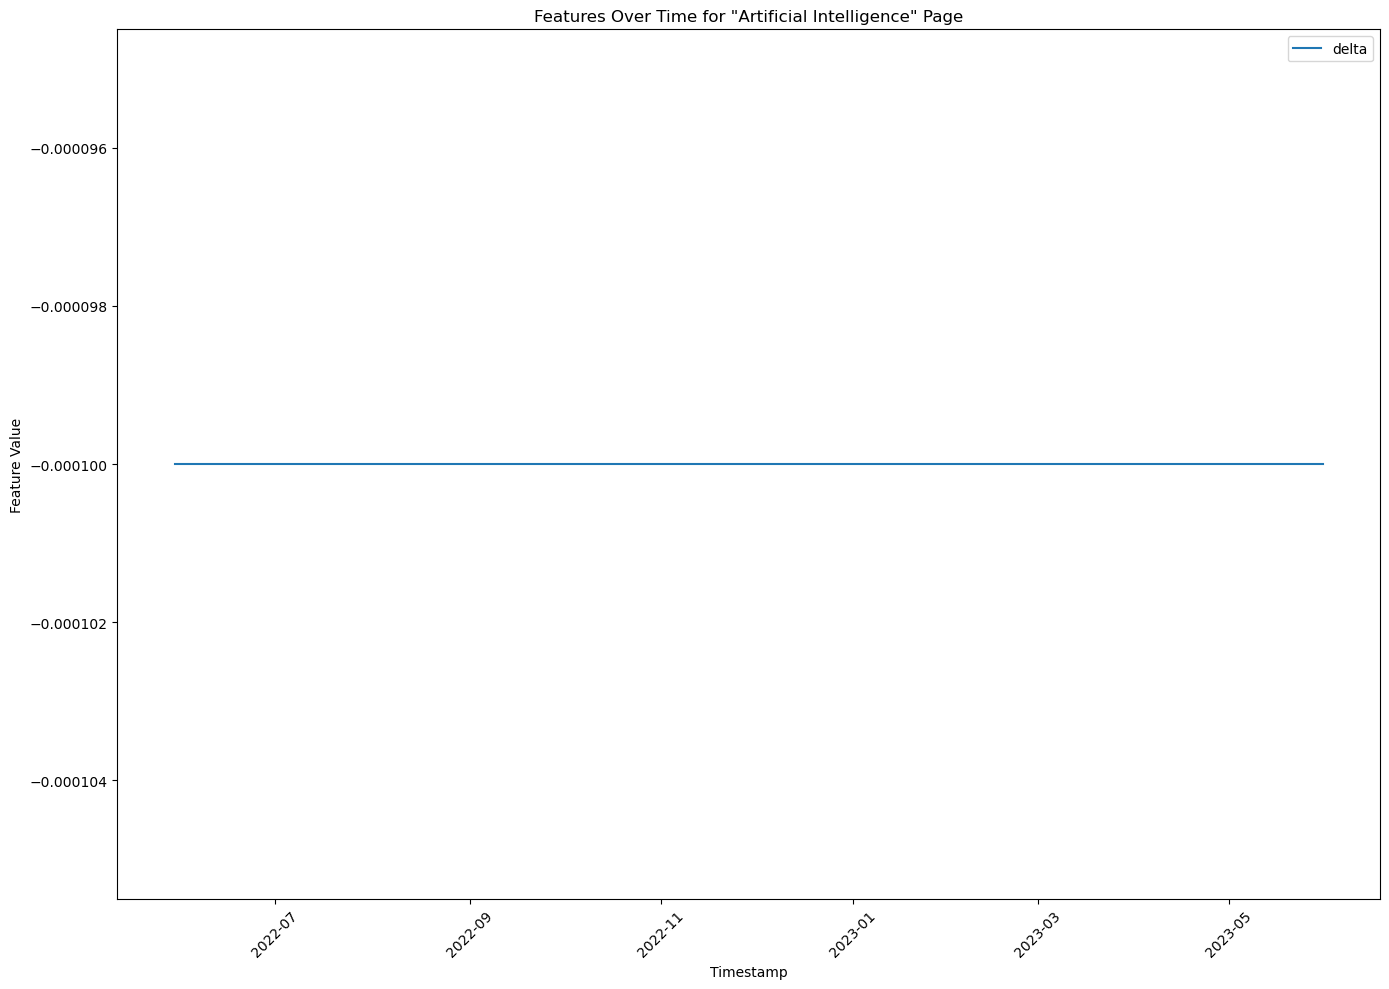

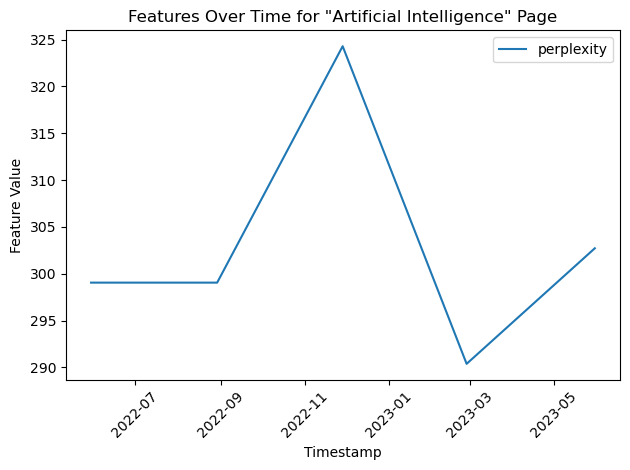

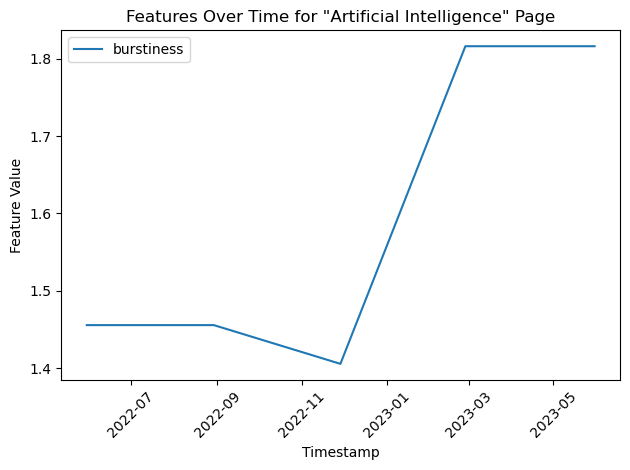

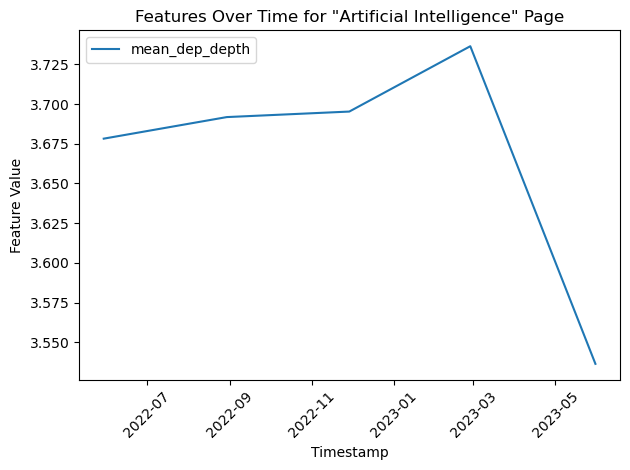

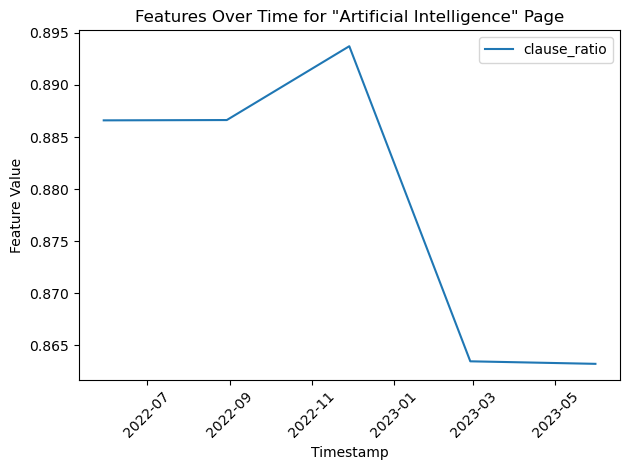

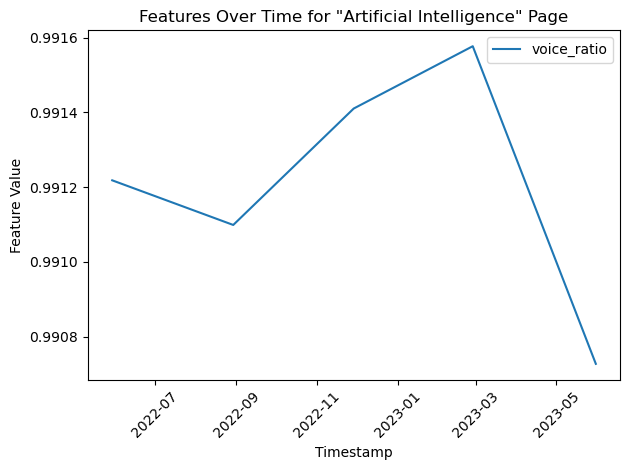

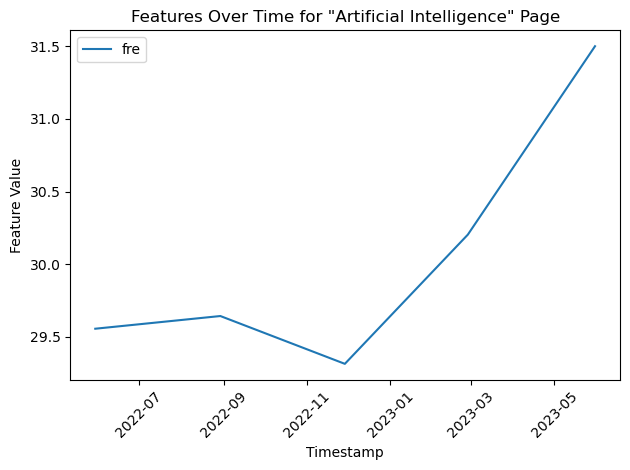

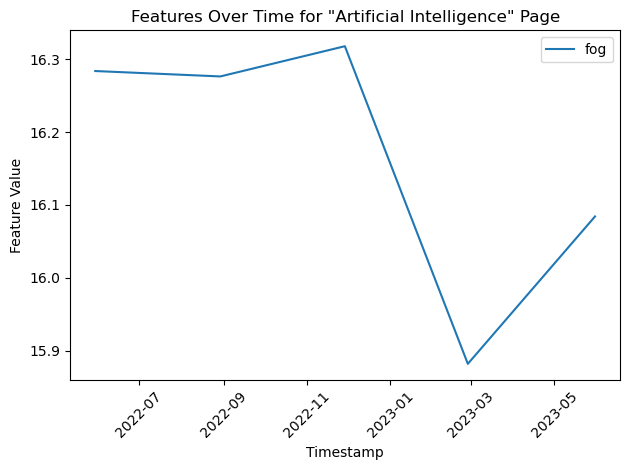

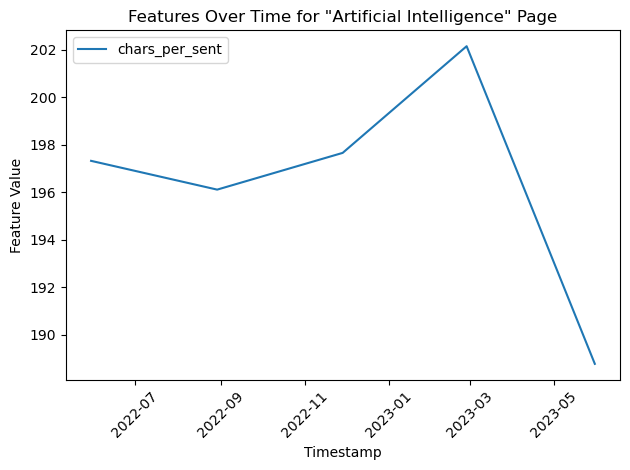

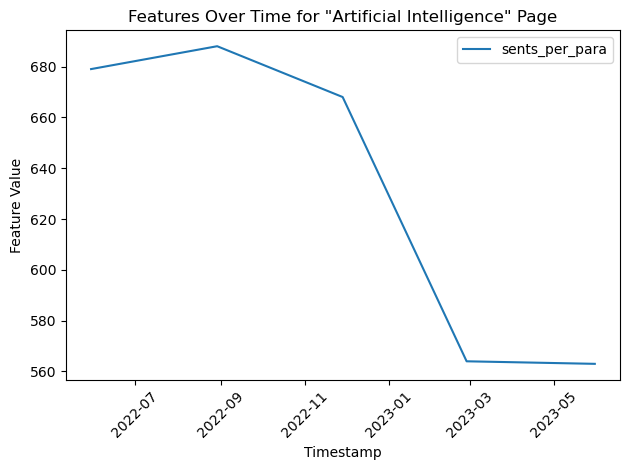

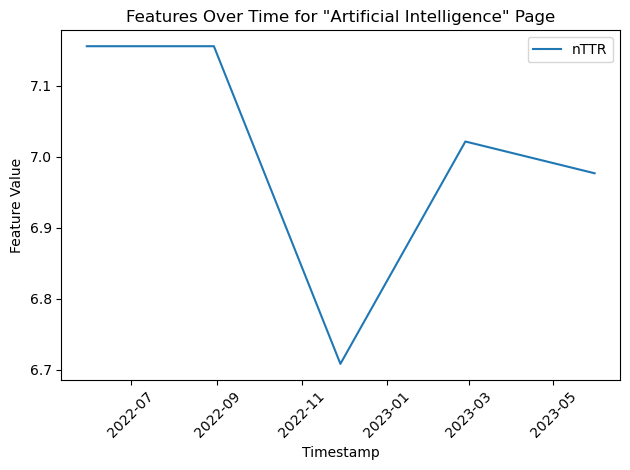

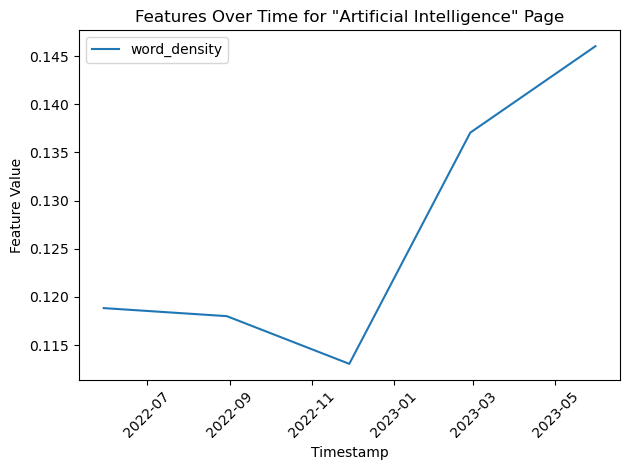

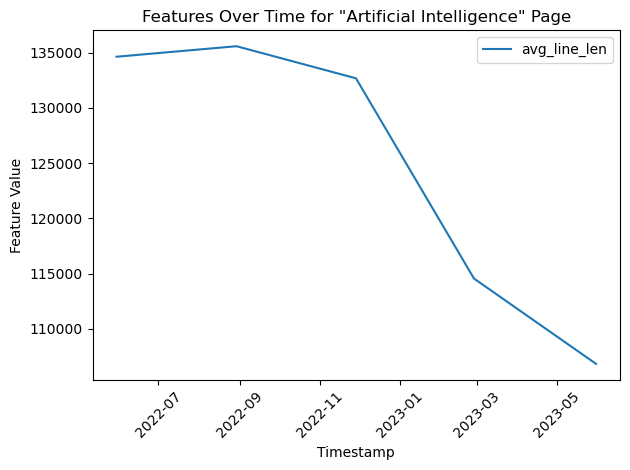

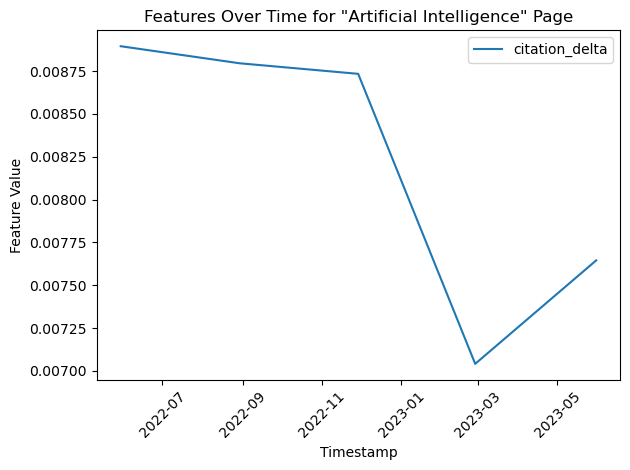

In [183]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace 'your_file.csv' with your actual file path
df = pd.read_csv('tiny_revisions_features.csv')

# Plot all columns (features) except 'page_title', 'rev_id', 'timestamp', 'user', 'is_bot', rev_id for the Artificial Intelligence page against the timestamp
ai_df = df[df['page_title'] == 'Artificial intelligence'].copy()

# Convert timestamp to datetime
ai_df['timestamp'] = pd.to_datetime(ai_df['timestamp'])
# Set timestamp as index
ai_df.set_index('timestamp', inplace=True)
# Plotting
plt.figure(figsize=(14, 10))
for column in ai_df.columns:
    if column not in ['page_title', 'rev_id', 'user', 'is_bot']:
        plt.plot(ai_df.index, ai_df[column], label=column)
        plt.title('Features Over Time for "Artificial Intelligence" Page')
        plt.xlabel('Timestamp')
        plt.ylabel('Feature Value')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()